In [10]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

_SEED = 42
random.seed(_SEED)
np.random.seed(_SEED)

In [5]:
data = pd.read_csv('../data/train.csv')
data.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [6]:
# Separate imageid
data['image_id'] = data.ImageId_ClassId.apply(lambda x: x.split('_')[0])
data['class_id'] = data.ImageId_ClassId.apply(lambda x: x.split('_')[1])
data.drop('ImageId_ClassId', axis=1, inplace=True)
data.head()

EncodedPixels       image_id class_id
0  29102 12 29346 24 29602 24 29858 24 30114 24 3...  0002cc93b.jpg        1
1                                                NaN  0002cc93b.jpg        2
2                                                NaN  0002cc93b.jpg        3
3                                                NaN  0002cc93b.jpg        4
4                                                NaN  00031f466.jpg        1

In [7]:
train_df = pd.DataFrame({
    'image_id': data['image_id'][::4]
})
train_df['defect_1'] = data.EncodedPixels[::4].values
train_df['defect_2'] = data.EncodedPixels[1::4].values
train_df['defect_3'] = data.EncodedPixels[2::4].values
train_df['defect_4'] = data.EncodedPixels[3::4].values
train_df['defect_count'] = train_df[train_df.columns[1:]].count(axis=1)
train_df.reset_index(inplace=True, drop=True)
train_df.fillna('', inplace=True)
print(train_df.info())
train_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12568 entries, 0 to 12567
Data columns (total 6 columns):
image_id        12568 non-null object
defect_1        12568 non-null object
defect_2        12568 non-null object
defect_3        12568 non-null object
defect_4        12568 non-null object
defect_count    12568 non-null int64
dtypes: int64(1), object(5)
memory usage: 589.2+ KB
None


image_id                                           defect_1 defect_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...            
1  00031f466.jpg                                                               
2  000418bfc.jpg                                                               
3  000789191.jpg                                                               
4  0007a71bf.jpg                                                               
5  000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...            
6  000f6bf48.jpg                                                               
7  0014fce06.jpg                                                               
8  001982b08.jpg                                                               
9  001d1b355.jpg                                                               

                                            defect_3  \
0                                                      
1                                                      
2                                                      
3                                                      
4  18661 28 18863 82 19091 110 19347 110 19603 11...   
5                                                      
6                                                      
7  229501 11 229741 33 229981 55 230221 77 230468...   
8                                                      
9                                                      

                                            defect_4  defect_count  
0                                                                1  
1                                                                0  
2                                                                0  
3                                                                0  
4                                                                1  
5                                                                1  
6  131973 1 132228 4 132483 6 132738 8 132993 11 ...             1  
7                                                                1  
8                                                                0  
9                                                                0

In [8]:
# Utility functions for RL encoding/decoding
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [180]:
class DataSequence(Sequence):
    def __init__(self, df, batch_size, img_size,
                 base_path='../data/train_images',
                 train=True, n_classes=4, n_channels=3,
                 shuffle=False, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.height, self.width = img_size
        self.base_path = base_path
        self.train = train
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
    
    def __len__(self):
        return int(np.ceil(len(self.df.index) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        flip_direction = None
        batch = self.df[idx*self.batch_size: (idx+1)*self.batch_size].reset_index(drop=True)
        images = np.zeros((len(batch.index), self.height, self.width, self.n_channels))
        if self.train:
            masks = np.zeros((len(batch.index), self.height, self.width, self.n_classes), dtype='int')
        for row in batch.itertuples():
            image = cv2.imread(f'{self.base_path}/{row.image_id}')
            assert image.shape == (self.height, self.width, self.n_channels), f'Image shape not as expected, got {image.shape}, expected {(self.height, self.width, self.n_channels)}'
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.augment:
                if random.random() > 0.5:
                    flip_direction = random.choice([-1, 0, 1])
                image = self.augment_image(image, row.defect_count, flip_direction=flip_direction)
            images[row.Index] = image / 255.
            if self.train:
                rles = row[2:-1]
                mask = self.build_mask(rles, flip_direction)
                masks[row.Index] = mask
        if self.train:
            return images, masks
        else:
            return images
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=_SEED).reset_index(drop=True)
    
    def illuminate(self, image):
        illumination = np.zeros((self.height, self.width), np.float32)
        cv2.circle(illumination, (random.choice(range(0, self.width)), random.choice(range(0, self.height))), random.choice(range(10, 150)), 1, -1, lineType=cv2.LINE_AA)
        illumination = cv2.GaussianBlur(illumination,(257,257),0)
        illumination = illumination.reshape(self.height, self.width, 1)
        image = image.astype(np.float32)/255
        image = image*(1+illumination*1.05)
        image = np.clip(image*255,0,255).astype(np.uint8)
        return image
    
    def augment_image(self, image, defect_count, flip_direction=None):
        if flip_direction is not None:
            image = cv2.flip(image, flip_direction)
        if random.random() > 0.5:
            alpha = random.uniform(1.0, 2.0) # Simple contrast control
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
        elif random.random() > 0.6:
            beta = random.randint(10, 61)    # Simple brightness control
            image = cv2.convertScaleAbs(image, alpha=1, beta=beta)
        if defect_count == 0:
            if random.random() > 0.5:
                print('illuminate')
                image = self.illuminate(image)
            if random.random() > 0.5:
                print('resize')
                crop_hw = [random.choice(range(10, self.height//10)), random.choice(range(10, self.width//10))]
                image = image[crop_hw[0]:-crop_hw[0], crop_hw[1]:-crop_hw[1], :]
                image = cv2.resize(image, (self.width, self.height))
            if random.random() > 0.5:
                transformation_matrix = np.float32([[1,0,random.choice(range(-self.width//4, self.width//4))],[0,1,random.choice(range(-self.height//10, self.height//10))]])
                image = cv2.warpAffine(image, transformation_matrix, (self.width, self.height))
        return image
    
    def build_mask(self, rles, flip_direction=None):
        assert self.n_classes == len(rles), 'length of rles should be same as number of classes'
        mask = np.zeros((self.height, self.width, self.n_classes), dtype='int')
        for i, rle in enumerate(rles):
            if type(rle) is str:
                m = rle2mask(rle, (self.width, self.height))
                if flip_direction is not None:
                    mask[:, :, i] = cv2.flip(m, flip_direction)
                else:
                    mask[:, :, i] = m
        return mask

In [181]:
def plot_image_with_mask(image, mask, title):
    img = image.copy()
    img[mask==1, 0] = 255
    plt.imshow(img)
    plt.title(title)
    plt.show()

W0924 18:27:58.591997 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 256, 1600, 3) (10, 256, 1600, 4)
1.0 0.0 1 0


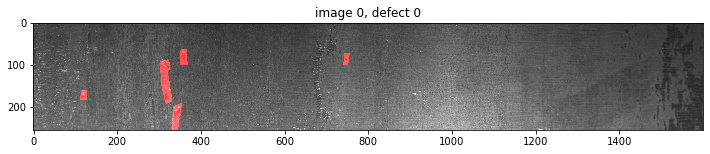

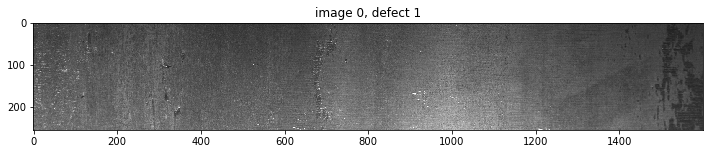

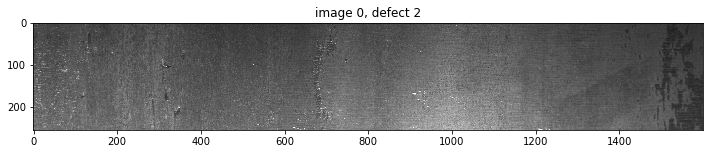

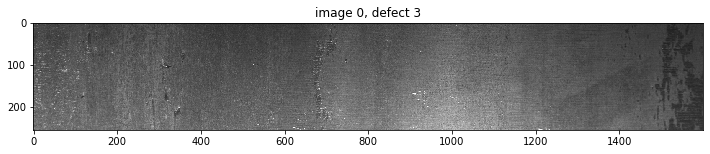

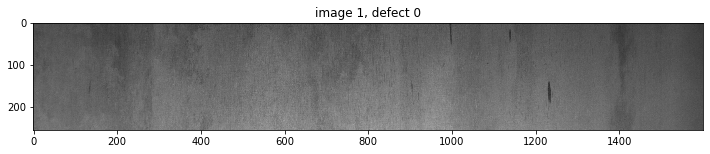

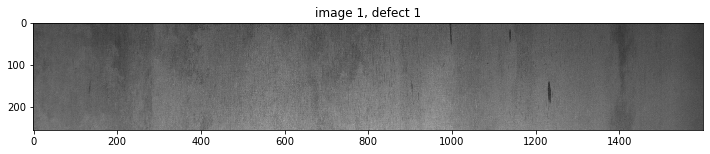

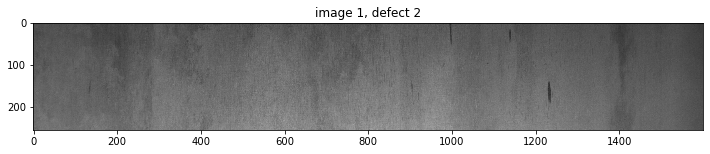

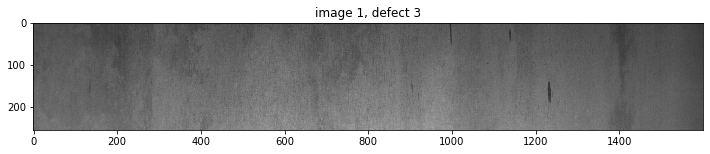

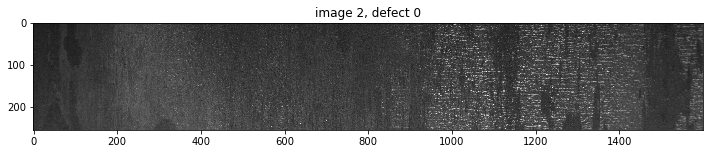

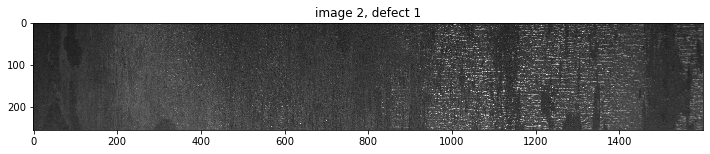

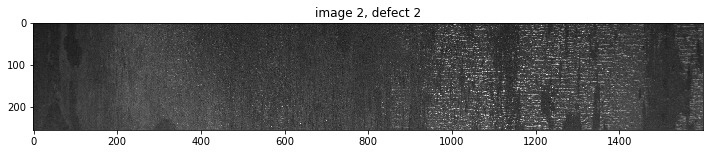

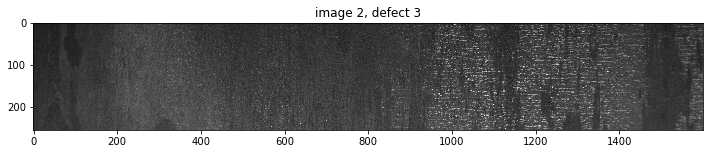

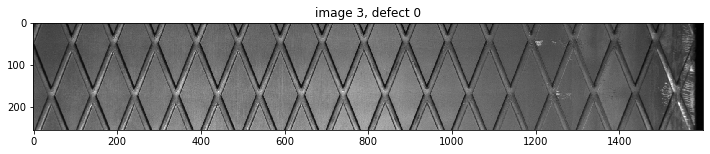

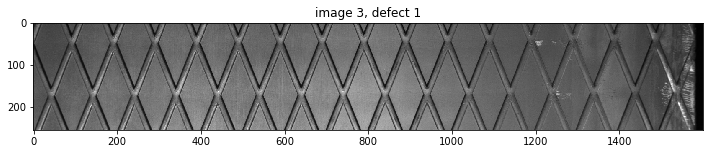

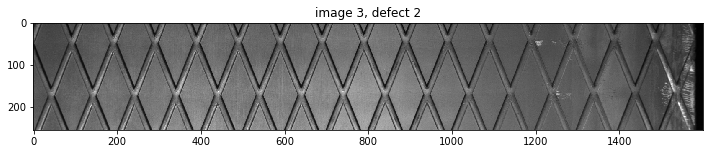

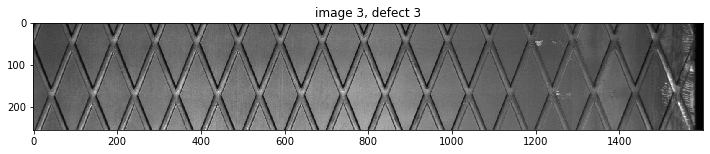

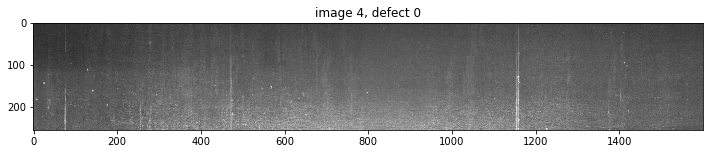

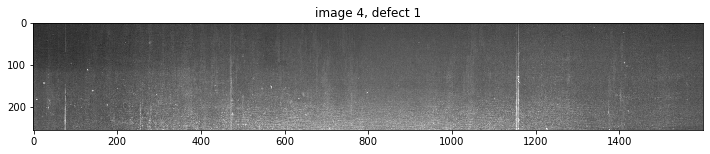

W0924 18:28:01.572593 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


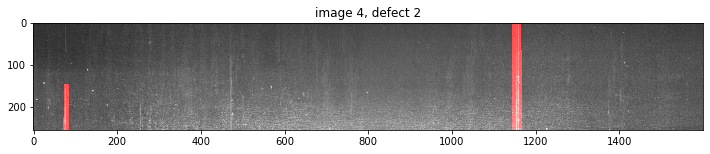

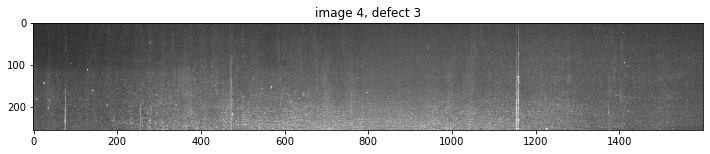

W0924 18:28:01.883681 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


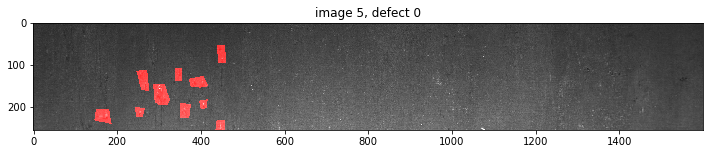

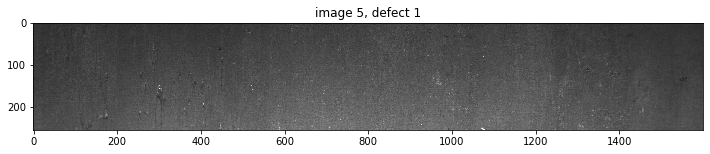

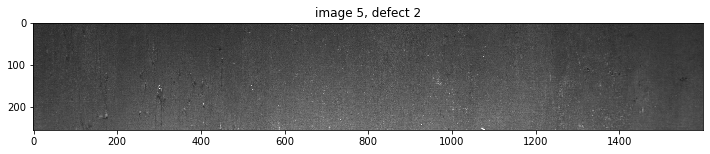

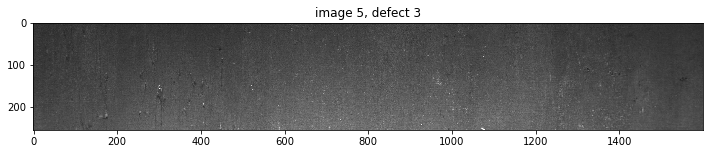

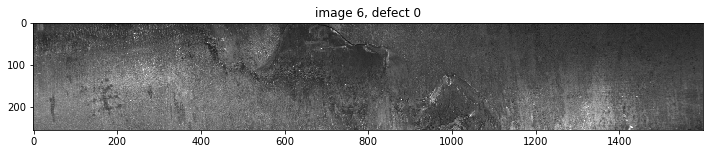

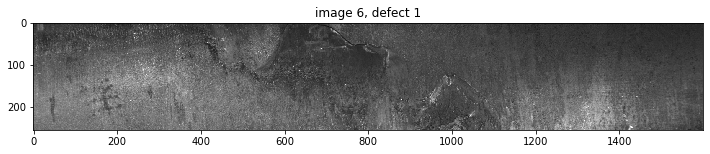

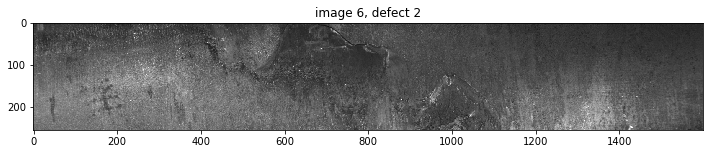

W0924 18:28:03.156134 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


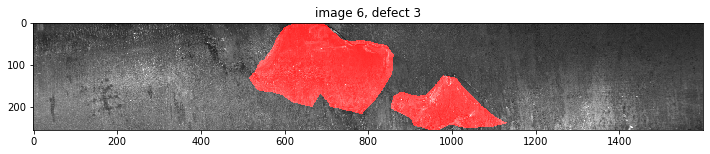

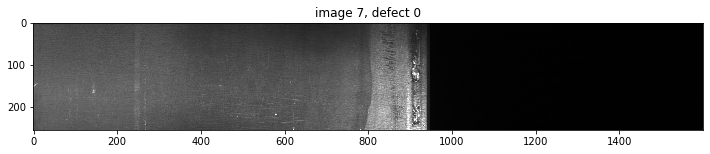

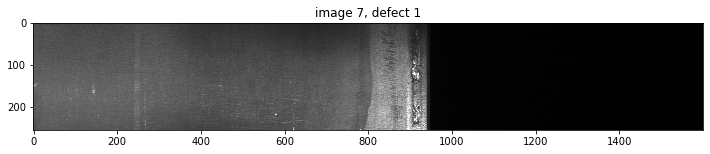

W0924 18:28:03.628187 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


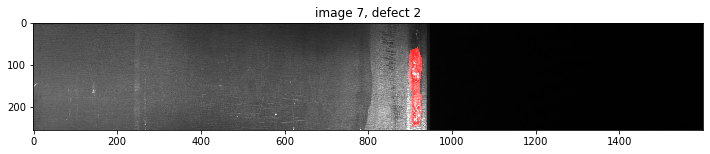

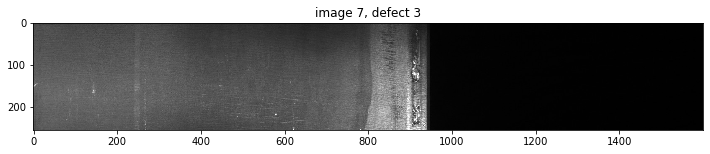

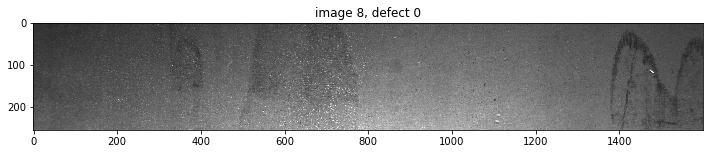

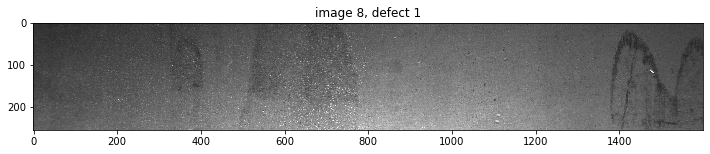

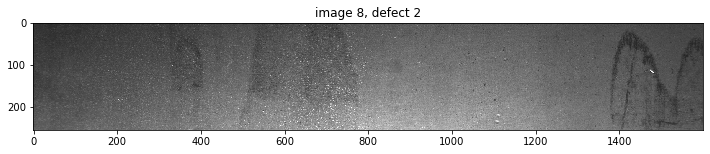

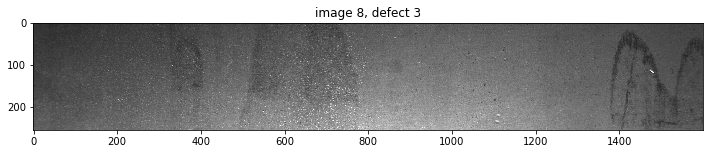

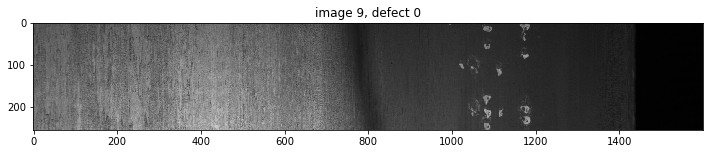

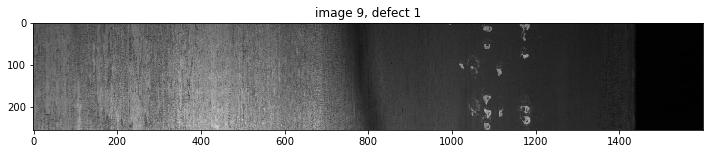

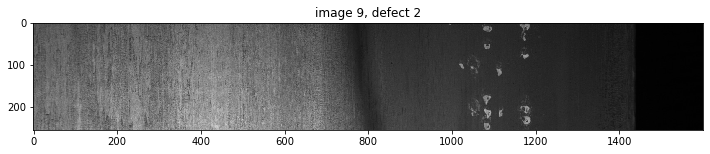

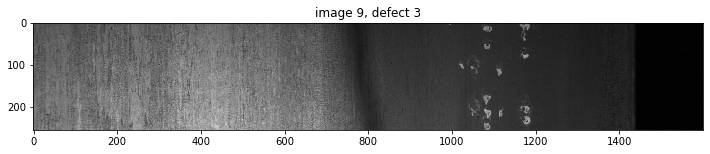

In [236]:
for x, y in DataSequence(train_df, 10, (256, 1600)):
    print(x.shape, y.shape)
    print(x.max(), x.min(), y.max(), y.min())
    for k in range(0, x.shape[0]):
        for i in range(0, y.shape[-1]):
            plot_image_with_mask(x[k], y[k][:,:,i], f'image {k}, defect {i}')
    break

illuminate
illuminate
resize
illuminate


W0924 18:28:11.114135 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


illuminate
(10, 256, 1600, 3) (10, 256, 1600, 4)
1.0 0.0 1 0


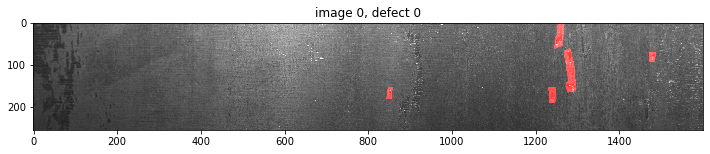

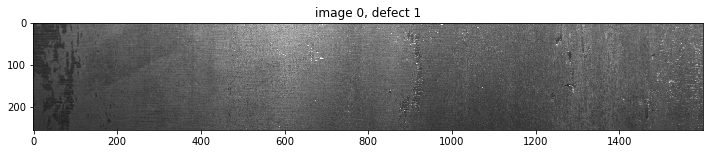

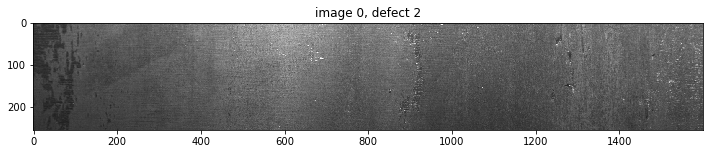

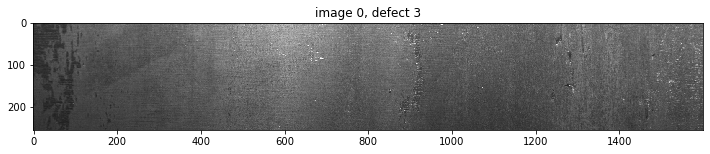

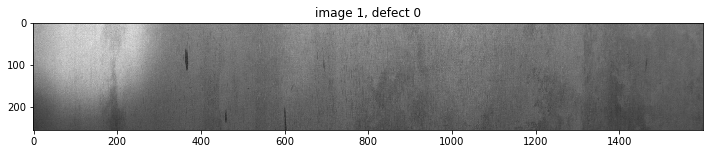

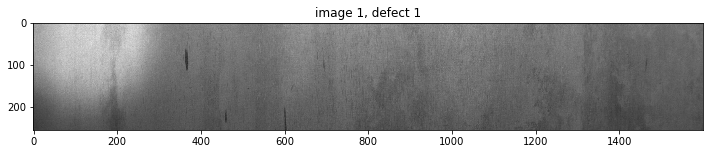

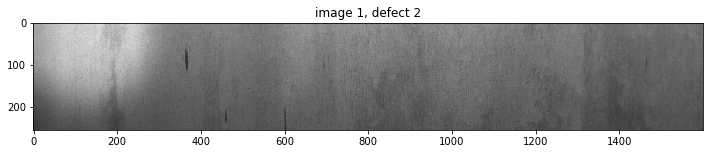

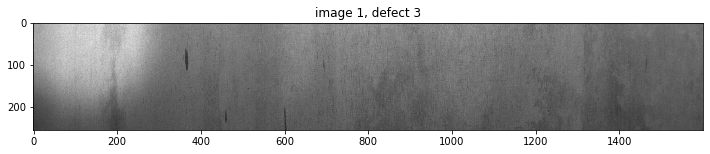

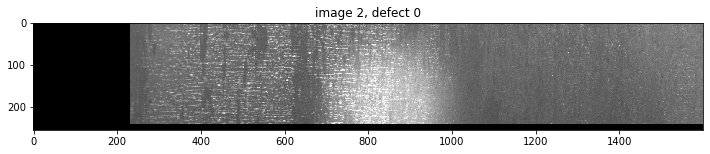

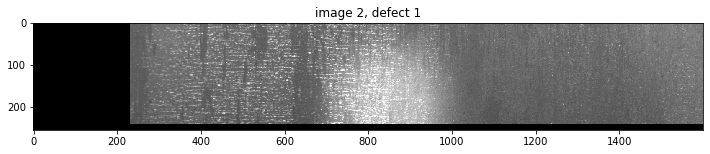

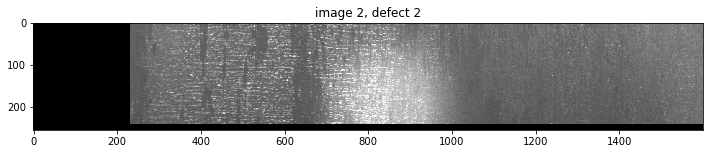

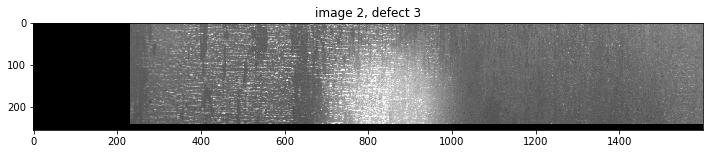

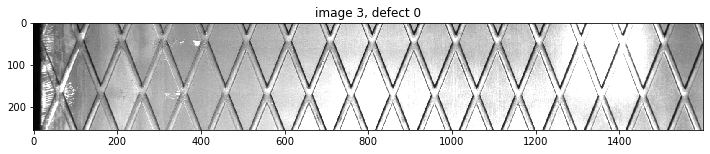

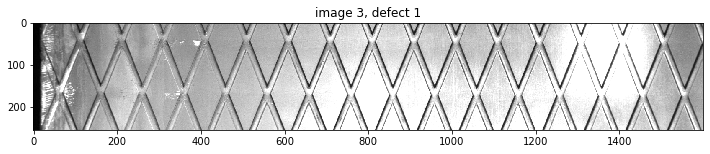

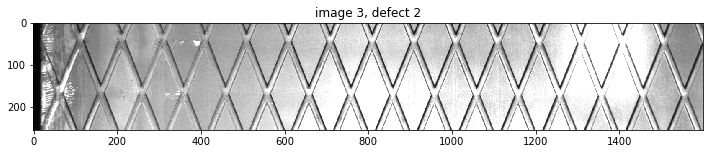

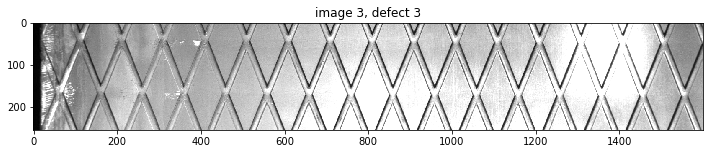

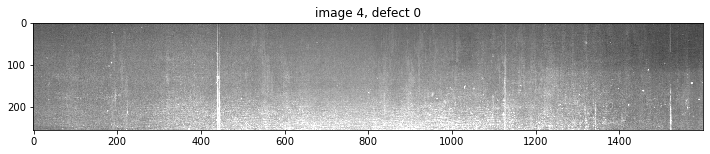

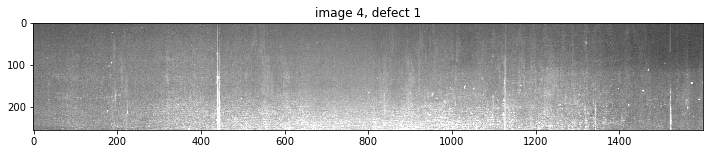

W0924 18:28:14.233760 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


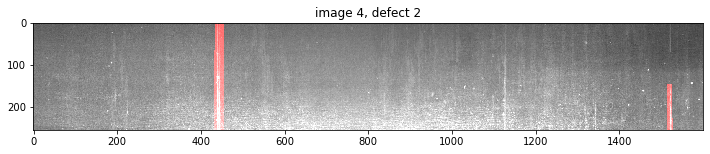

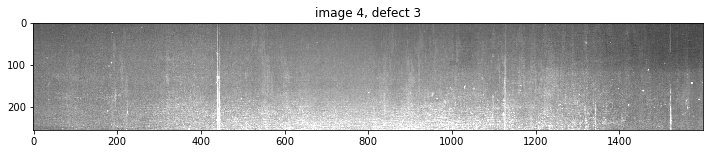

W0924 18:28:14.611214 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


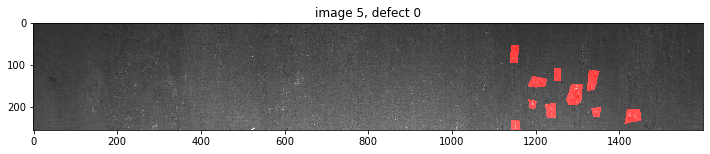

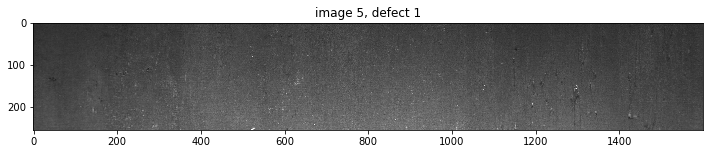

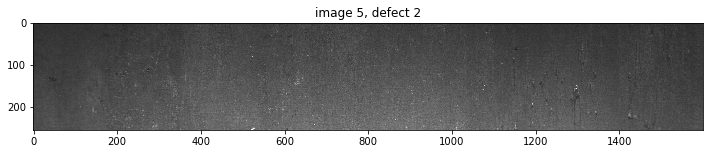

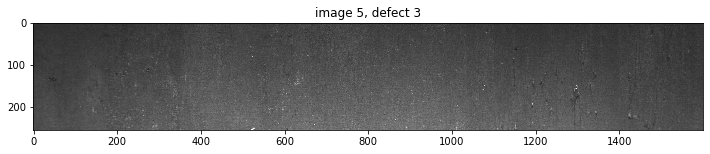

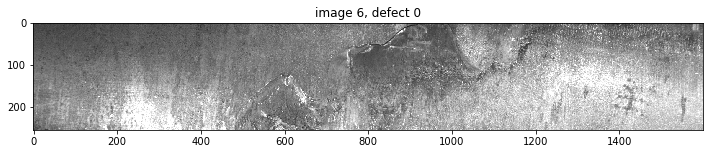

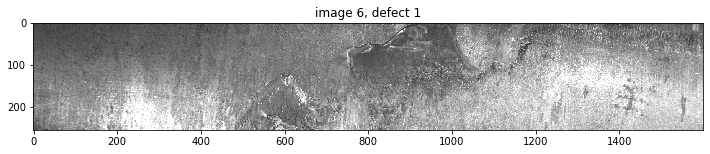

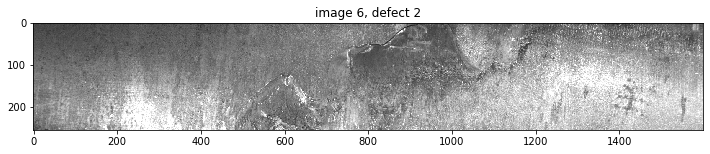

W0924 18:28:15.948354 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


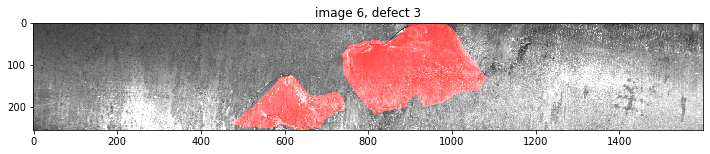

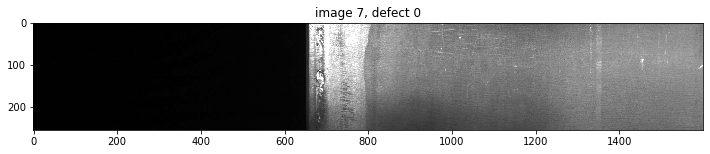

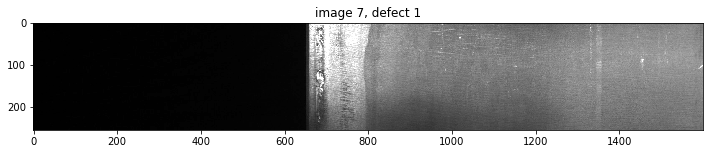

W0924 18:28:16.501326 139904436045632 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


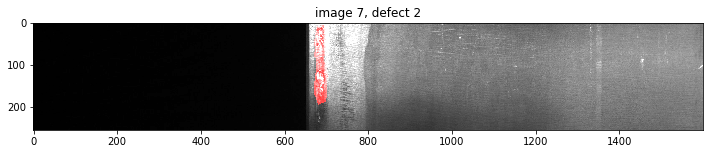

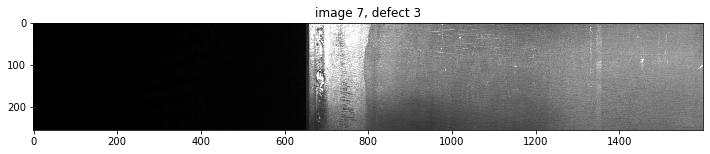

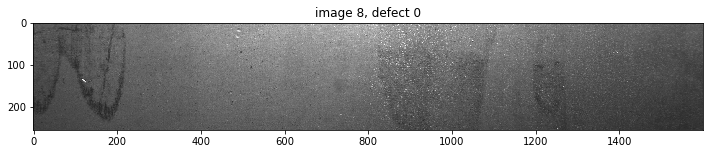

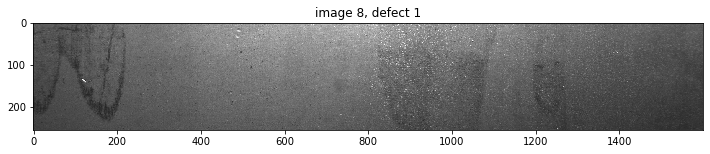

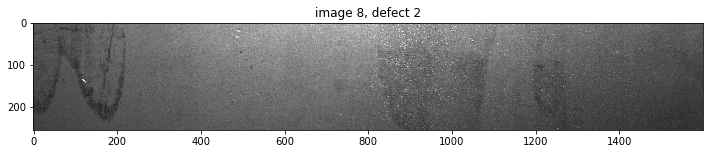

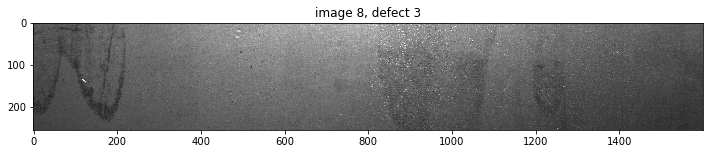

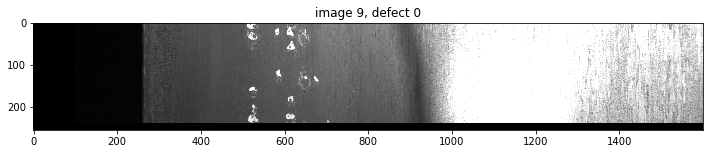

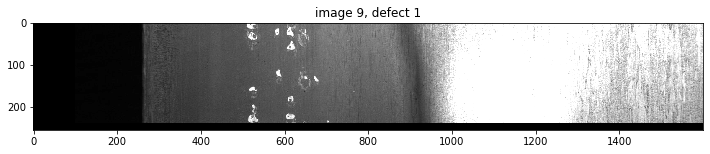

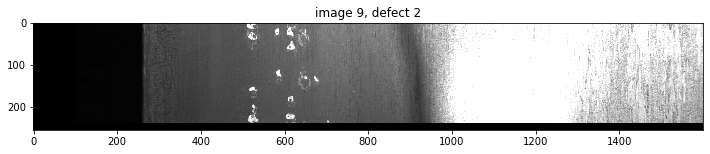

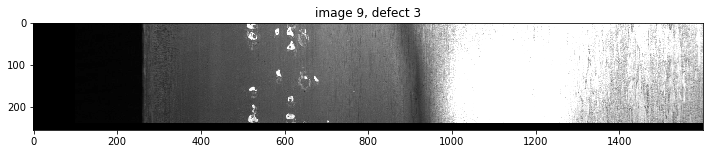

In [237]:
for x, y in DataSequence(train_df, 10, (256, 1600), augment=True):
    print(x.shape, y.shape)
    print(x.max(), x.min(), y.max(), y.min())
    for k in range(0, x.shape[0]):
        for i in range(0, y.shape[-1]):
            plot_image_with_mask(x[k], y[k][:,:,i], f'image {k}, defect {i}')
    break